# Input Data Processing

## Input Data:
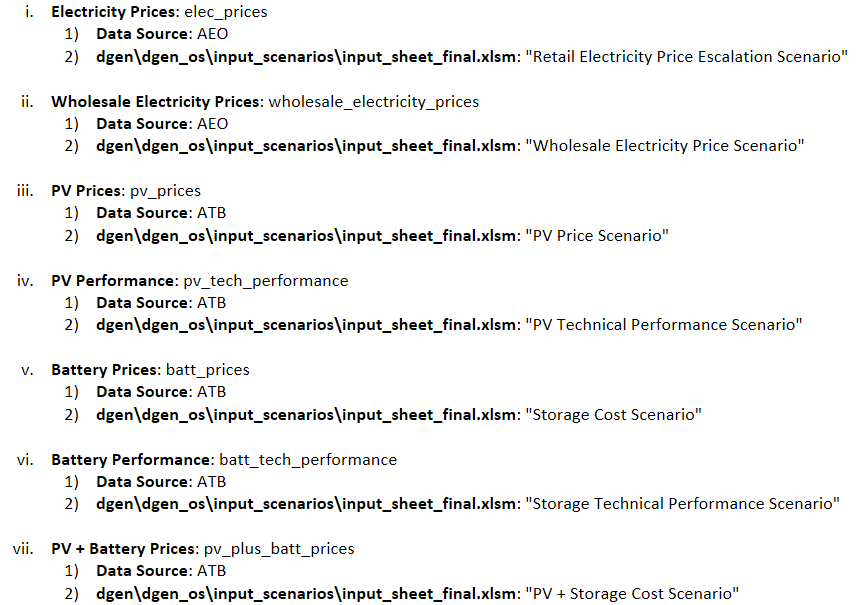

## Electricity Prices

In [19]:
# Input Data Processing: Electricity Prices



## Wholesale Electricity Prices

In [21]:
# Input Data Processing: Wholesale Electricity Prices



## PV Prices

In [23]:
# Input Data Processing: PV Prices



## PV Performance

In [25]:
# Input Data Processing: PV Performance



## Battery Prices

In [27]:
# Input Data Processing: Battery Prices



## Battery Performance

In [29]:
# Input Data Processing: Battery Performance



## PV + Battery Prices

In [31]:
# Input Data Processing: PV + Battery Prices

